<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Nakanoshima_surgery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# prompt: gdrive

from google.colab import drive
drive.mount('/content/drive')

!pip install japanize_matplotlib --q
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# フォント設定を最初に行う
plt.rcParams['font.family'] = 'IPAexGothic'
sns.set(font='IPAexGothic', font_scale=2.5)  # font_scale を2.5に増加
plt.rcParams['axes.unicode_minus'] = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


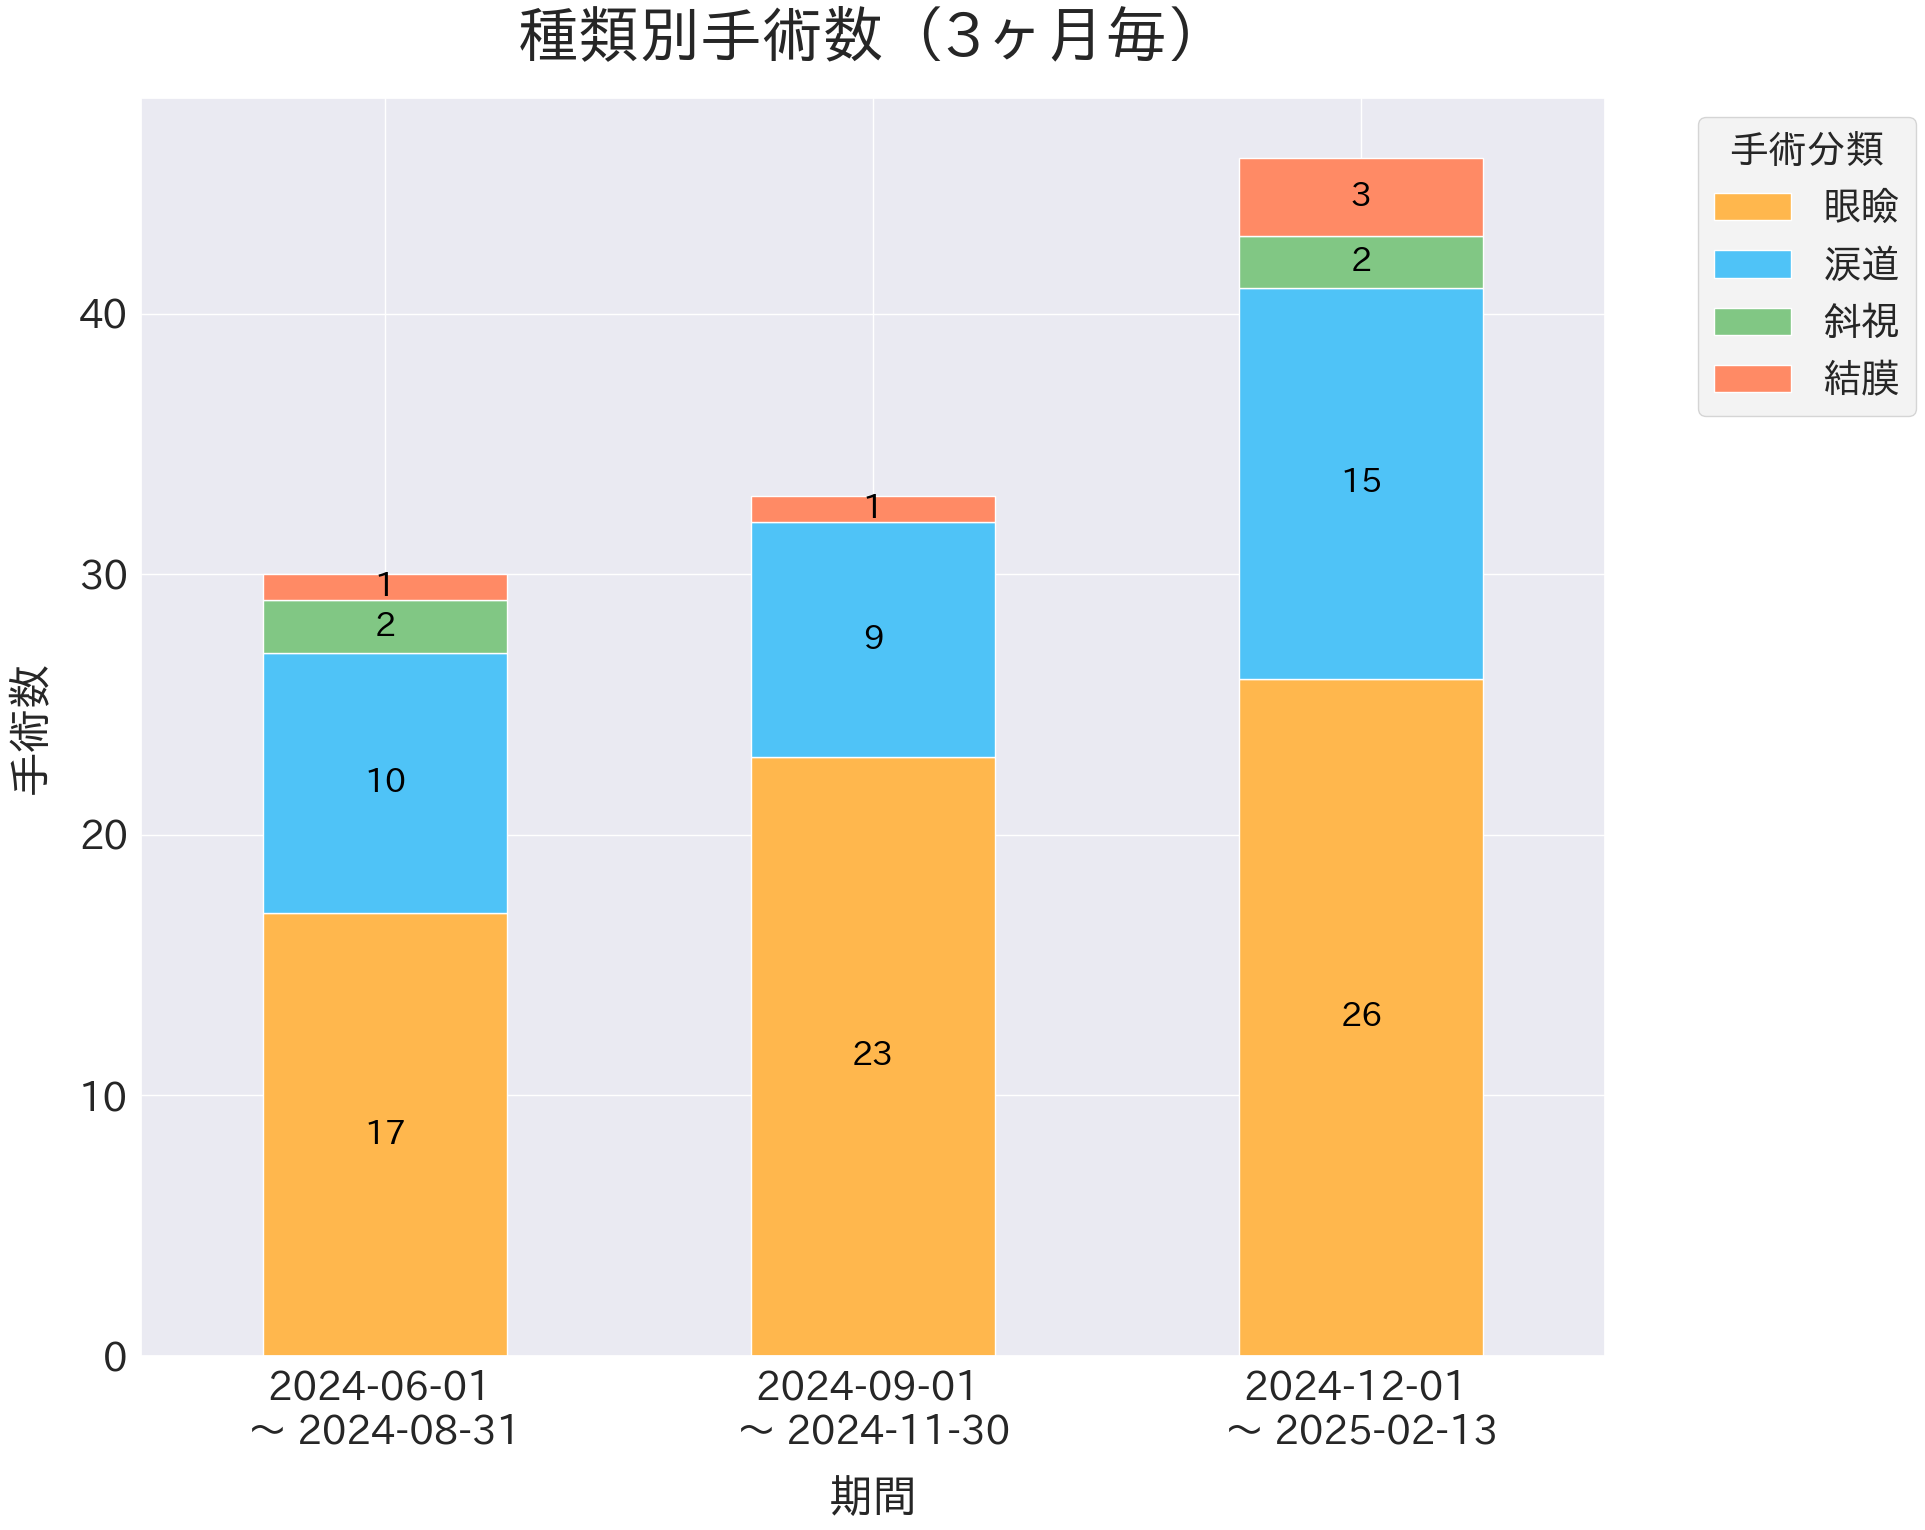

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 新しいファイルの読み込み
file_path = "/content/drive/MyDrive/阪大業務/中之島アイセンターCLINIC書類/中之島手術.xlsx"
df = pd.read_excel(file_path)



# 列名の空白を削除
df.columns = df.columns.str.strip()

# n_sideの欠損行を除外
df = df.dropna(subset=['n_side'])

# 日付をdatetime型に変換
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# n_sideが1の場合は1件、2の場合は2件として手術数をカウント
df['surgery_count'] = df['n_side'].apply(lambda x: 1 if x == 1 else (2 if x == 2 else 0))

# 新しい3ヶ月ごとの期間を再作成（2024-05-30を開始、6月1日-9月1日も含める）
date_ranges = [
    pd.Timestamp('2024-05-30'),
    pd.Timestamp('2024-06-01'),
    pd.Timestamp('2024-09-01'),
    pd.Timestamp('2024-12-01'),
    pd.Timestamp('2025-02-13')
]

# 5月30日を含む期間を6月1日～9月1日に統合するように期間割り当てを修正
def assign_period(date):
    if pd.Timestamp('2024-05-30') <= date < pd.Timestamp('2024-09-01'):
        return "2024-06-01 \n〜 2024-08-31"
    elif pd.Timestamp('2024-09-01') <= date < pd.Timestamp('2024-12-01'):
        return "2024-09-01 \n〜 2024-11-30"
    elif pd.Timestamp('2024-12-01') <= date <= pd.Timestamp('2025-02-13'):
        return "2024-12-01 \n〜 2025-02-13"
    else:
        return "その他"

# 新しい期間割り当てを適用
df['Period'] = df['Date'].apply(assign_period)

# "その他" のデータを除外
filtered_df = df[df['Period'] != 'その他']

# 各期間・手術分類ごとの手術数を再集計
period_surgery_counts = filtered_df.groupby(['Period', 'Classification (1眼瞼、2涙道、3斜視、4結膜など)'])['surgery_count'].sum().reset_index()

# ピボットテーブルを作成する前に、元データのClassification列を日本語にマッピング
classification_labels = {
    1: '眼瞼',
    2: '涙道',
    3: '斜視',
    4: '結膜'
}

# 元データに日本語の手術分類列を追加
filtered_df['Classification_JP'] = filtered_df['Classification (1眼瞼、2涙道、3斜視、4結膜など)'].map(classification_labels)

# 新しいピボットテーブルを作成
pivot_df = filtered_df.pivot_table(
    index='Period',
    columns='Classification_JP',
    values='surgery_count',
    aggfunc='sum'
).fillna(0)

import matplotlib.pyplot as plt

# X軸ラベルをシンプルな形式に変更
def simplify_period_label(period):
    start, end = period.split(" ~ ")
    start_year, start_month = start.split("-")[:2]
    end_month = end.split("-")[1]
    return f"{start_year}年{int(start_month)}-{int(end_month)}月"

# 色と表示順序を指定
classification_order = ['眼瞼', '涙道', '斜視', '結膜']
colors = ['#FFB74D', '#4FC3F7', '#81C784', '#FF8A65']

# インデックスに改行を挿入
pivot_df.index = [label.replace('月', '月\n〜', 1) for label in pivot_df.index]

# 色と表示順序を指定
classification_order = ['眼瞼', '涙道', '斜視', '結膜']
colors = ['#FFB74D', '#4FC3F7', '#81C784', '#FF8A65']

# ピボットテーブルの列を指定順に並べ替え
pivot_df = pivot_df[classification_order]

# 積み上げ棒グラフを作成
fig, ax = plt.subplots(figsize=(20, 16))
bars = pivot_df.plot(kind='bar', stacked=True, figsize=(20, 16), ax=ax, color=colors)

# フォントサイズ設定
title_fontsize = 44
label_fontsize = 32
tick_fontsize = 28
legend_fontsize = 28
data_label_fontsize = 24

# タイトルと軸ラベルのフォントサイズ調整
plt.title('種類別手術数（3ヶ月毎）', fontsize=title_fontsize, weight='bold', pad=30)
plt.xlabel('期間', fontsize=label_fontsize, labelpad=20)
plt.ylabel('手術数', fontsize=label_fontsize, labelpad=20)
plt.xticks(rotation=0, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# 凡例を下から「眼瞼 → 涙道 → 斜視 → 結膜」の順で表示
handles, labels = ax.get_legend_handles_labels()
ordered_handles = [handles[labels.index(label)] for label in classification_order]
ax.legend(ordered_handles, classification_order, title='手術分類',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          fontsize=legend_fontsize, title_fontsize=legend_fontsize, frameon=True).get_frame().set_facecolor('#F0F0F0')

# データラベルを各バーセグメントに追加
for bar_container in bars.containers:
    for bar in bar_container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                        xytext=(0, 0),
                        textcoords='offset points',
                        ha='center', va='center',
                        fontsize=data_label_fontsize, weight='bold', color='black')

plt.tight_layout()
plt.show()



#**Sedation**

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 新しいファイルの読み込み
file_path = "/content/drive/MyDrive/阪大業務/中之島アイセンターCLINIC書類/中之島手術.xlsx"
df = pd.read_excel(file_path)

# 欠損値を含む行を削除
df_clean = df.dropna(subset=["Classification (1眼瞼、2涙道、3斜視、4結膜など)", "Sedation"])

# ClassificationとSedationごとの件数を集計
classification_sedation_counts = df_clean.groupby(
    ["Classification (1眼瞼、2涙道、3斜視、4結膜など)", "Sedation"]
).size().unstack(fill_value=0)


classification_sedation_counts


Sedation,0.0,1.0
Classification (1眼瞼、2涙道、3斜視、4結膜など),,
1.0,34,12
2.0,8,18
3.0,0,2
4.0,5,0


In [ ]:
import matplotlib.pyplot as plt

# データの準備
labels = ["結膜手術", "斜視手術", "涙道手術", "眼瞼手術"]
sedation_yes = classification_sedation_counts.loc[[4.0, 3.0, 2.0, 1.0], 1.0]
sedation_no = classification_sedation_counts.loc[[4.0, 3.0, 2.0, 1.0], 0.0]

# プロットの設定
plt.figure(figsize=(10, 6))

# 背景色を白に設定
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# 横向きの積み上げ棒グラフ作成
plt.barh(labels, sedation_yes, color='#2E5AAC', label="Yes")  # 深いブルー
plt.barh(labels, sedation_no, left=sedation_yes, color='#A4A4A4', label="No")  # より濃いグレー

# グラフの装飾
plt.xlabel("Number of Cases")
#plt.title("静脈内鎮静の有無")
plt.grid(axis='x', linestyle='--', alpha=0.3)  # グリッド線を追加して視認性を向上

# 凡例の設定（タイトル付き）
plt.legend(title="静脈内鎮静")

plt.tight_layout()

# グラフ表示
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 必要な列
pain_columns = ['Pain_injection', 'Pain_incision', 'Pain_postop', 'Pain_experience']

# 数値型に変換
for column in pain_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# 'Sedation'列を確認してリネーム
df.rename(columns={'Sedation': 'sedation'}, inplace=True)

# sedationが0と1の群を抽出してlong形式に変換
group_0 = df[df['sedation'] == 0][pain_columns].dropna().melt(var_name="Pain_Type", value_name="Pain_Score")
group_0["Sedation"] = "No"

group_1 = df[df['sedation'] == 1][pain_columns].dropna().melt(var_name="Pain_Type", value_name="Pain_Score")
group_1["Sedation"] = "Yes"

# 両群を統合
pain_combined = pd.concat([group_0, group_1])

# ラベル置き換え辞書
label_mapping = {
    'Pain_injection': '麻酔注射の痛み',
    'Pain_incision': '手術中の痛み',
    'Pain_postop': '終了時の痛み',
    'Pain_experience': '手術の体験'
}

# Pain_Type列を置き換え
pain_combined['Pain_Type'] = pain_combined['Pain_Type'].map(label_mapping)

# グラフ描画
sns.set(font='IPAexGothic', font_scale=3)  # フォントとサイズ設定
plt.figure(figsize=(14, 10))

# ボックスプロットの中央値を赤く太線に設定
ax = sns.boxplot(
    data=pain_combined,
    x="Pain_Type",
    y="Pain_Score",
    hue="Sedation",
    medianprops={'color': 'red', 'linewidth': 1.5}  # 中央値の色と太さ指定
)

# y軸の範囲設定
plt.ylim(0, 10)

# x軸基準線を強調
plt.axhline(y=0, color='black', linewidth=1.5)

# ラベル設定
plt.ylabel('痛みスコア', fontsize=24)
plt.xlabel('痛みの種類', fontsize=24)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title="鎮静の有無", fontsize=20, title_fontsize=18)

# グリッド線を見やすく
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#**Eyelid_QOL**